W oparciu o dostępne atrybuty zbuduj model, który pomoże oszacować, czy dana nieruchomość należy do klasy cheap, average czy expensive. Do dyspozycji mają Państwo dane treningowe (train_data.csv) z oryginalnymi cenami nieruchomości (SalePrice), oraz, tak jak ostatnio, zbiór testowy (test_data.csv).
Proszę przygotować kod, który pozwoli na uzyskanie DOKŁADNIE tych samych predykcji, które zostały dołączone w pliku wynikowym. W tym celu proszę zadbać o odpowiednie seedy losowych modułów itp.

W ramach rozwiązania, proszę oddać poprzez Teamsy plik - archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze test_data.csv.
W pliku z predykcjami powinna się znajdować dokładnie jedna kolumna, oznaczająca przewidywaną przez Państwa klasę ceny mieszkania (0 <- cheap, 1 <- average, 2 <- expensive).
Końcowe wyniki obliczał będę w oparciu o średnią dokładność dla każdej klasy. Proszę zwrócić uwagę na fakt, że klasy są mocno niezbalansowane!
Koniecznie proszę sprawdzić format zwracanych przez Państwa predykcji (tyle predykcji ile elementów w zbiorze testowym, brak nagłówków, jedna kolumna, itd.)
Bardzo proszę nazywać wszystkie pliki nazwiskami autorów (najlepiej alfabetycznie), lub nazwą zespołu. Nazwę głównego archiwum zip proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_ (nie pon/pia), proszę też nie umieszczać plików w dodatkowych podfolderach tylko bezpośrednio .
W MS Teams wszystkim przydzieliłem zadanie, ale bardzo proszę, żeby tylko jeden (dowolny) członek zespołu je zwrócił.
W razie pytań zapraszam do korespondencji lub na konsultacje.


In [ ]:
import sys
torch.cuda.empty_cache()
sys.modules[__name__].__dict__.clear()
!nvidia-smi

Tue Nov  8 20:15:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import math
import pandas as pd
import numpy as np
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from google.colab import drive
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import struct
import random

Załóżmy, że chcemy kupić mieszkanie. Do dyspozycji mamy 100 000 dolarów, możemy też wziąć kredyt na kolejne 250 tysięcy, co da nam w sumie budżet w wysokości 350 000 dolarów. Chcemy móc przewidzieć, czy mieszkanie o pewnych, zadanych parametrach, możemy kupić za własne pieniądze (cheap), z kredytem (average), czy jest poza naszym zasięgiem (expensive).

In [102]:

df = pd.read_csv("train_data.csv", delimiter=',')
df
train_df = df.sample(frac=0.8,random_state=100) 
test_df = df.drop(train_df.index)

train_data = train_df.copy()
eval_data = test_df.copy()

def label_price(row):
    value = row[0]
    if value < 100000:
        return 0.    # "CHEAP"
    elif 100000 < value < 350000:
        return 1.    # "AVERAGE"
    else:
        return 2.    # "EXPENSIVE"
        
def binary(num,bit_number=16):
    # return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))
    # return bitstring.BitArray(float=num, length=int(bit_number)).bin
    return format(int(num), 'b').zfill(bit_number)


def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix).astype(np.int64)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)

    return df
def rnd_noise(x,std):
  return random.gauss(0, x*std)

def fdf2bindf(data,string,std,train_or_test=1,bit_number=16):
  name = string
  column_name = [name]
  i = 1
  zeta = 0.
  global datax
  global data_new
  if train_or_test == 0:
    datax = data[column_name].iloc[0].apply(lambda x: binary(x+rnd_noise(x,std),bit_number)).apply(lambda x: pd.Series(list(x)))
  else:
    datax = data[column_name].iloc[0].apply(lambda x: binary(x,bit_number)).apply(lambda x: pd.Series(list(x)))

  variable_names = [f"{i}" + string for i in range(1,bit_number+1)]
  
  row_name = str(data[column_name].index[0])
  datax.rename(index={string:row_name},inplace=True)
  for index, row in data[column_name].iterrows():
    if train_or_test == 0:
      data_new = data[column_name].iloc[i].apply(lambda x: binary(x+rnd_noise(x,std),bit_number)).apply(lambda x: pd.Series(list(x)))
    else:
      data_new = data[column_name].iloc[i].apply(lambda x: binary(x,bit_number)).apply(lambda x: pd.Series(list(x)))
    row_name = str(data[column_name].index[i])
    data_new.rename(index={string:row_name},inplace=True)
    datax = pd.concat([datax,data_new])
    i = +1
  datax.columns = variable_names
  data.drop(columns=column_name,inplace=True)
  return datax.iloc[:-1,:],data

def cdum(data,string):
  cc = [string]
  cce = pd.get_dummies(data[cc].astype(str))
  cce.head()
  data.drop(columns=cc,inplace=True)
  return cce,data

def augument_data(data,std,n_samples):
  sample_set = data.sample().apply(lambda x: x+rnd_noise(x,std))
  for j in range(0,n_samples-1):
    new_sample_set = data.sample().apply(lambda x: x+rnd_noise(x,std))
    for column in new_sample_set:
      new_sample_set[column] = new_sample_set[column].apply(lambda x: 0. if x <=0.5  else (1. if 1.-x*std*2< x <=1.+x*std*2 else (2. if 2.-x*std*2< x <=2.+x*std*2 else x)))
    sample_set = pd.concat([sample_set,new_sample_set])
    sample_set['Sale Price Encoded'] = sample_set.apply(lambda row: label_price(row), axis=1)
  return sample_set

print(train_data.shape)
print(eval_data.shape)
#test_df
#train_df

std = 0.05
noise_b = 1
bin_TimeToBusStopEncoded = 7
bin_TimeToSubwayEncoded= 7
bin_N_SchoolNearBy_Total = 7
bin_N_FacilitiesNearBy_Total = 7
bin_N_FacilitiesInApt= 7
bin_N_elevators= 7
bin_N_manager = 4
bin_N_Parkinglot_Basement= 12
bin_N_Parkinglot_Ground = 10
bin_Floor= 7
bin_Size_sqf = 12
bin_YearBuilt = 12
bin_SalePrice = 24

(3299, 17)
(825, 17)


In [103]:
# Loading eta +-5min


label_encoder =LabelEncoder()
train_data['Sale Price Encoded'] = train_data.apply(lambda row: label_price(row), axis=1)
eval_data['Sale Price Encoded'] = eval_data.apply(lambda row: label_price(row), axis=1)
n_train_clasess = train_data['Sale Price Encoded'].value_counts()
n_test_clasess = eval_data['Sale Price Encoded'].value_counts()
print(n_train_clasess)
print(n_test_clasess)


train_data['TimeToBusStopEncoded']= label_encoder.fit_transform(train_data['TimeToBusStop'])
train_data['TimeToSubwayEncoded']= label_encoder.fit_transform(train_data['TimeToSubway'])  
train_data
train_data = train_data.drop(columns=["TimeToBusStop","TimeToSubway"])

train_data.HallwayType.unique()
train_data = onehot_encode(train_data, 'HallwayType', 'HallwayTypeEncoded')
train_data.AptManageType.unique()
train_data = onehot_encode(train_data, 'AptManageType', 'AptManageTypeEncoded')
train_data.SubwayStation.unique()
train_data = onehot_encode(train_data, 'SubwayStation', 'SubwayStationEncoded')
train_data.HeatingType.unique()
train_data = onehot_encode(train_data, 'HeatingType', 'HeatingTypeEncoded')

# ################ Upsample ############################# 
# from sklearn.utils import resample

train_cheap = train_data[train_data['Sale Price Encoded'] == 0.]
train_avg = train_data[train_data['Sale Price Encoded'] == 1.]
train_exp = train_data[train_data['Sale Price Encoded'] == 2.]

# train_cheap_upsampled = resample(train_cheap,replace=True,n_samples= train_avg.shape[0],random_state=42) 
# train_exp_upsampled = resample(train_exp, replace=True,n_samples= train_avg.shape[0],random_state=42)  

# train_data = pd.concat([train_cheap_upsampled,train_avg])
# train_data = pd.concat([train_data,train_exp_upsampled])
################ Upsample ############################# 

# ################ Upsample ############################# # WITH NOISE - Bad idea??
# n_exp = train_avg.shape[0] - train_exp.shape[0]
# n_cheap = train_avg.shape[0] - train_cheap.shape[0]
# cheap_aug = augument_data(train_cheap,0.1,n_cheap)
# exp_aug = augument_data(train_exp,0.1,n_exp)
# train_data = pd.concat([train_data,cheap_aug])
# train_data = pd.concat([train_data,exp_aug])
# ################ Upsample ############################# # WITH NOISE

################## CUT THE DATA ##########################
# train_avg = train_avg.sample(train_exp.shape[0])
# del train_data
# train_data = pd.concat([train_cheap,train_avg])
# train_data = pd.concat([train_data,train_exp])
################## CUT THE DATA ##########################

train_labels_multiclass = pd.get_dummies(train_data['Sale Price Encoded'])
train_labels_multiclass.head()
test_labels_multiclass = pd.get_dummies(eval_data['Sale Price Encoded'])
test_labels_multiclass.head()

train_data.drop(columns=['Sale Price Encoded'],inplace=True)
eval_data.drop(columns=['Sale Price Encoded'],inplace=True)

tTimeToBusStopEncoded,train_data = fdf2bindf(train_data,"TimeToBusStopEncoded",std,noise_b,bin_TimeToBusStopEncoded) 
tTimeToSubwayEncoded,train_data = fdf2bindf(train_data,"TimeToSubwayEncoded",std,noise_b,bin_TimeToSubwayEncoded) 
tN_SchoolNearBy_Total,train_data = fdf2bindf(train_data,'N_SchoolNearBy(Total)',std,noise_b,bin_N_SchoolNearBy_Total)
tN_FacilitiesNearBy_Total,train_data = fdf2bindf(train_data,'N_FacilitiesNearBy(Total)',std,noise_b,bin_N_FacilitiesNearBy_Total)
tN_FacilitiesInApt,train_data = fdf2bindf(train_data,"N_FacilitiesInApt",std,noise_b,bin_N_FacilitiesInApt)
tN_elevators,train_data = fdf2bindf(train_data,'N_elevators',std,noise_b,bin_N_elevators)
tN_manager,train_data = fdf2bindf(train_data,'N_manager',std,noise_b,bin_N_manager)
tN_Parkinglot_Basement,train_data = fdf2bindf(train_data,'N_Parkinglot(Basement)',std,noise_b,bin_N_Parkinglot_Basement)
tN_Parkinglot_Ground,train_data = fdf2bindf(train_data,'N_Parkinglot(Ground)',std,noise_b,bin_N_Parkinglot_Ground)
tFloor,train_data = fdf2bindf(train_data,'Floor',std,noise_b,bin_Floor)
tSize_sqf,train_data = fdf2bindf(train_data,'Size(sqf)',std,noise_b,bin_Size_sqf)
tYearBuilt,train_data = fdf2bindf(train_data,'YearBuilt', std,noise_b,bin_YearBuilt)
tSalePrice,train_data = fdf2bindf(train_data,'SalePrice',std,noise_b,bin_SalePrice)

eval_data['TimeToBusStopEncoded']= label_encoder.fit_transform(eval_data['TimeToBusStop'])
eval_data['TimeToSubwayEncoded']= label_encoder.fit_transform(eval_data['TimeToSubway'])
eval_data = eval_data.drop(columns=["TimeToBusStop","TimeToSubway"])

eval_data.HallwayType.unique()
eval_data = onehot_encode(eval_data, 'HallwayType', 'HallwayTypeEncoded')
eval_data.AptManageType.unique()
eval_data = onehot_encode(eval_data, 'AptManageType', 'AptManageTypeEncoded')
eval_data.SubwayStation.unique()
eval_data = onehot_encode(eval_data, 'SubwayStation', 'SubwayStationEncoded')
eval_data.HeatingType.unique()
eval_data = onehot_encode(eval_data, 'HeatingType', 'HeatingTypeEncoded')

eTimeToBusStopEncoded,eval_data = fdf2bindf(eval_data,'TimeToBusStopEncoded',std,1,bin_TimeToBusStopEncoded)  
eTimeToSubwayEncoded,eval_data = fdf2bindf(eval_data,"TimeToSubwayEncoded",std,1,bin_TimeToSubwayEncoded) 
eN_SchoolNearBy_Total,eval_data = fdf2bindf(eval_data,'N_SchoolNearBy(Total)',std,1,bin_N_SchoolNearBy_Total)
eN_FacilitiesNearBy_Total,eval_data = fdf2bindf(eval_data,'N_FacilitiesNearBy(Total)',std,1,bin_N_FacilitiesNearBy_Total)
eN_FacilitiesInApt,eval_data = fdf2bindf(eval_data,"N_FacilitiesInApt",std,1,bin_N_FacilitiesInApt)
eN_elevators,eval_data = fdf2bindf(eval_data,'N_elevators',std,1,bin_N_elevators)
eN_manager,eval_data = fdf2bindf(eval_data,'N_manager',std,1,bin_N_manager)
eN_Parkinglot_Basement,eval_data = fdf2bindf(eval_data,'N_Parkinglot(Basement)',std,1,bin_N_Parkinglot_Basement)
eN_Parkinglot_Ground,eval_data = fdf2bindf(eval_data,'N_Parkinglot(Ground)',std,1,bin_N_Parkinglot_Ground)
eFloor,eval_data = fdf2bindf(eval_data,'Floor',std,1,bin_Floor)
eSize_sqf,eval_data = fdf2bindf(eval_data,'Size(sqf)',std,1,bin_Size_sqf)
eYearBuilt,eval_data = fdf2bindf(eval_data,'YearBuilt', std,1,bin_YearBuilt)
eSalePrice,eval_data = fdf2bindf(eval_data,'SalePrice',std,1,bin_SalePrice)


1.0    2380
0.0     465
2.0     454
Name: Sale Price Encoded, dtype: int64
1.0    612
2.0    122
0.0     91
Name: Sale Price Encoded, dtype: int64


In [104]:
train_indices = np.random.rand(len(train_data))>0.
tTimeToBusStopEncoded_torch = torch.from_numpy(tTimeToBusStopEncoded.values.astype(float)[train_indices]).float()
tTimeToSubwayEncoded_torch = torch.from_numpy(tTimeToSubwayEncoded.values.astype(float)[train_indices]).float()
tN_SchoolNearBy_Total_torch = torch.from_numpy(tN_SchoolNearBy_Total.values.astype(float)[train_indices]).float()
tN_FacilitiesNearBy_Total_torch = torch.from_numpy(tN_FacilitiesNearBy_Total.values.astype(float)[train_indices]).float()
tN_FacilitiesInApt_torch = torch.from_numpy(tN_FacilitiesInApt.values.astype(float)[train_indices]).float()
tN_elevators_torch = torch.from_numpy(tN_elevators.values.astype(float)[train_indices]).float()
tN_manager_torch = torch.from_numpy(tN_manager.values.astype(float)[train_indices]).float()
tN_Parkinglot_Basement_torch = torch.from_numpy(tN_Parkinglot_Basement.values.astype(float)[train_indices]).float()
tN_Parkinglot_Ground_torch = torch.from_numpy(tN_Parkinglot_Ground.values.astype(float)[train_indices]).float()
tFloor_torch = torch.from_numpy(tFloor.values.astype(float)[train_indices]).float()
tSize_sqf_torch = torch.from_numpy(tSize_sqf.values.astype(float)[train_indices]).float()
tYearBuilt_torch = torch.from_numpy(tYearBuilt.values.astype(float)[train_indices]).float()

eTimeToBusStopEncoded_torch = torch.from_numpy(eTimeToBusStopEncoded.values.astype(float)).float()
eTimeToSubwayEncoded_torch = torch.from_numpy(eTimeToSubwayEncoded.values.astype(float)).float()
eN_SchoolNearBy_Total_torch = torch.from_numpy(eN_SchoolNearBy_Total.values.astype(float)).float()
eN_FacilitiesNearBy_Total_torch = torch.from_numpy(eN_FacilitiesNearBy_Total.values.astype(float)).float()
eN_FacilitiesInApt_torch = torch.from_numpy(eN_FacilitiesInApt.values.astype(float)).float()
eN_elevators_torch = torch.from_numpy(eN_elevators.values.astype(float)).float()
eN_manager_torch = torch.from_numpy(eN_manager.values.astype(float)).float()
eN_Parkinglot_Basement_torch = torch.from_numpy(eN_Parkinglot_Basement.values.astype(float)).float()
eN_Parkinglot_Ground_torch = torch.from_numpy(eN_Parkinglot_Ground.values.astype(float)).float()
eFloor_torch = torch.from_numpy(eFloor.values.astype(float)).float()
eSize_sqf_torch = torch.from_numpy(eSize_sqf.values.astype(float)).float()
eYearBuilt_torch = torch.from_numpy(eYearBuilt.values.astype(float)).float()

rest_train_torch = torch.from_numpy(train_data.values.astype(float)[train_indices]).float()
rest_eval_torch = torch.from_numpy(eval_data.values.astype(float)).float()
train_labels_torch = torch.from_numpy(train_labels_multiclass.values[train_indices]).float().float()
test_labels_torch = torch.from_numpy(test_labels_multiclass.values).float().float()

ta,tb,tc,td,te,tf,tg,th,ti,tj,tk,tl,tm,tn = rest_train_torch,tTimeToBusStopEncoded_torch,tTimeToSubwayEncoded_torch,tN_SchoolNearBy_Total_torch,tN_FacilitiesNearBy_Total_torch,tN_FacilitiesInApt_torch,tN_elevators_torch,tN_manager_torch,tN_Parkinglot_Basement_torch,tN_Parkinglot_Ground_torch,tFloor_torch,tSize_sqf_torch,tYearBuilt_torch,train_labels_torch
ea,eb,ec,ed,ee,ef,eg,eh,ei,ej,ek,el,em,en = rest_eval_torch,eTimeToBusStopEncoded_torch,eTimeToSubwayEncoded_torch,eN_SchoolNearBy_Total_torch,eN_FacilitiesNearBy_Total_torch,eN_FacilitiesInApt_torch,eN_elevators_torch,eN_manager_torch,eN_Parkinglot_Basement_torch,eN_Parkinglot_Ground_torch,eFloor_torch,eSize_sqf_torch,eYearBuilt_torch,test_labels_torch
print(ta.size(),tb.size(),tc.size(),td.size(),te.size(),tf.size(),tg.size(),th.size(),ti.size(),tj.size(),tk.size(),tl.size(),tm.size(),tn.size())
print(ea.size(),eb.size(),ec.size(),ed.size(),ee.size(),ef.size(),eg.size(),eh.size(),ei.size(),ej.size(),ek.size(),el.size(),em.size(),en.size())

input_length = ta.size(1)+tb.size(1)+tc.size(1)+td.size(1)+te.size(1)+tf.size(1)+tg.size(1)+th.size(1)+ti.size(1)+tj.size(1)+tk.size(1)+tl.size(1)+tm.size(1)+tn.size(1)
#input_length

torch.Size([3299, 15]) torch.Size([3299, 7]) torch.Size([3299, 7]) torch.Size([3299, 7]) torch.Size([3299, 7]) torch.Size([3299, 7]) torch.Size([3299, 7]) torch.Size([3299, 4]) torch.Size([3299, 12]) torch.Size([3299, 10]) torch.Size([3299, 7]) torch.Size([3299, 12]) torch.Size([3299, 12]) torch.Size([3299, 3])
torch.Size([825, 15]) torch.Size([825, 7]) torch.Size([825, 7]) torch.Size([825, 7]) torch.Size([825, 7]) torch.Size([825, 7]) torch.Size([825, 7]) torch.Size([825, 4]) torch.Size([825, 12]) torch.Size([825, 10]) torch.Size([825, 7]) torch.Size([825, 12]) torch.Size([825, 12]) torch.Size([825, 3])


In [105]:
train_dataset = data.TensorDataset(ta,tb,tc,td,te,tf,tg,th,ti,tj,tk,tl,tm,tn)
test_dataset = data.TensorDataset(ea,eb,ec,ed,ee,ef,eg,eh,ei,ej,ek,el,em,en)

train_data_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

In [123]:
device = torch.device("cuda") 

def get_accuracy(model, data_loader):
    correct = 0.
    epoch_losses = []
    model.eval() #*********#
    for a,b,c,d,e,f,g,h,i,j,k,l,m, labels in iter(data_loader):
        a,b,c,d,e,f,g,h,i,j,k,l,m, labels = a.to(device),b.to(device),c.to(device),d.to(device),e.to(device),f.to(device),g.to(device),h.to(device),i.to(device),j.to(device),k.to(device),l.to(device),m.to(device), labels.to(device)
        output = model(a,b,c,d,e,f,g,h,i,j,k,l,m)
        loss = criterion(out, labels)
        epoch_losses.append(loss.item())

    loss_mean = np.array(epoch_losses).mean()
    correct = (out.argmax(dim=1) == labels.argmax(dim=1)).sum().float() / float( labels.size(0) )
    return correct,loss_mean


class MulticlassClassifier(nn.Module):
    def __init__(self,  a,b,c,d,e,f,g,h,i,j,k,l,m):

        super().__init__()
        self.num_inputs = int((a.shape[1] +b.shape[1]+c.shape[1]+d.shape[1]+e.shape[1]+f.shape[1]+g.shape[1]+h.shape[1]+i.shape[1]+j.shape[1]+k.shape[1]+l.shape[1]+m.shape[1])*2)
        self.num_hidden1 = int(self.num_inputs*4)
        self.num_hidden2 = int(self.num_inputs*2)
        self.num_hidden3 = int(self.num_inputs)
        self.num_outputs = 3
        
        # Initialize the modules we need to build the network
        self.emb_a = nn.Linear(a.shape[1], a.shape[1])
        self.act_emb_a = nn.PReLU(num_parameters=a.shape[1], init=0.25)
        self.emb_b = nn.Linear(b.shape[1], b.shape[1])
        self.act_emb_b = nn.PReLU(num_parameters=b.shape[1], init=0.25)
        self.emb_c = nn.Linear(c.shape[1], c.shape[1])
        self.act_emb_c = nn.PReLU(num_parameters=c.shape[1], init=0.25)
        self.emb_d = nn.Linear(d.shape[1], d.shape[1])
        self.act_emb_d = nn.PReLU(num_parameters=d.shape[1], init=0.25)
        self.emb_e = nn.Linear(e.shape[1], e.shape[1])
        self.act_emb_e = nn.PReLU(num_parameters=e.shape[1], init=0.25)
        self.emb_f = nn.Linear(f.shape[1], f.shape[1])
        self.act_emb_f = nn.PReLU(num_parameters=f.shape[1], init=0.25)
        self.emb_g = nn.Linear(g.shape[1], g.shape[1])
        self.act_emb_g = nn.PReLU(num_parameters=g.shape[1], init=0.25)
        self.emb_h = nn.Linear(h.shape[1], h.shape[1])
        self.act_emb_h = nn.PReLU(num_parameters=h.shape[1], init=0.25)
        self.emb_i = nn.Linear(i.shape[1], i.shape[1])
        self.act_emb_i = nn.PReLU(num_parameters=i.shape[1], init=0.25)
        self.emb_j = nn.Linear(j.shape[1], j.shape[1])
        self.act_emb_j = nn.PReLU(num_parameters=j.shape[1], init=0.25)
        self.emb_k = nn.Linear(k.shape[1], k.shape[1])
        self.act_emb_k = nn.PReLU(num_parameters=k.shape[1], init=0.25)
        self.emb_l = nn.Linear(l.shape[1], l.shape[1])
        self.act_emb_l = nn.PReLU(num_parameters=l.shape[1], init=0.25)
        self.emb_m = nn.Linear(m.shape[1], m.shape[1])
        self.act_emb_m = nn.PReLU(num_parameters=m.shape[1], init=0.25)
        
        self.input = nn.Linear(a.shape[1] +b.shape[1]+c.shape[1]+d.shape[1]+e.shape[1]+f.shape[1]+g.shape[1]+h.shape[1]+i.shape[1]+j.shape[1]+k.shape[1]+l.shape[1]+m.shape[1], self.num_inputs)

        self.bn1 = nn.BatchNorm1d(self.num_inputs)

        self.neural_block1 = nn.Sequential(
        nn.PReLU(num_parameters=self.num_inputs, init=0.25),#xx||
        nn.Dropout(0.1),#xx||
        nn.Linear(self.num_inputs,self.num_hidden1),
        nn.PReLU(num_parameters=self.num_hidden1, init=0.25),
        nn.Dropout(0.3),
        nn.Linear(self.num_hidden1,self.num_hidden2),
        nn.BatchNorm1d(self.num_hidden2),#xx||
        nn.PReLU(num_parameters=self.num_hidden2, init=0.25),
        #nn.AdaptiveMaxPool1d(self.num_hidden2),#xx||
        nn.Dropout(0.3),
        nn.Linear(self.num_hidden2,self.num_hidden2),#xx||
        nn.BatchNorm1d(self.num_hidden2),#xx||
        nn.PReLU(num_parameters=self.num_hidden2, init=0.25),#xx||
        nn.AdaptiveMaxPool1d(self.num_hidden2),#xx||
        nn.Dropout(0.3),#xx||
        )

        self.neural_block2 =  nn.Sequential(
        nn.Linear(self.num_hidden2,self.num_hidden3),
        )
        self.bn2 = nn.BatchNorm1d(self.num_hidden3)#xx||

        self.neural_block3 =  nn.Sequential(
        nn.PReLU(num_parameters=self.num_hidden3, init=0.25),#xx||
        nn.Dropout(0.2),#xx||
        nn.AdaptiveAvgPool1d(self.num_hidden3),#xx||
        nn.Linear(self.num_hidden3, self.num_outputs),
        )
        
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1/np.sqrt(self.num_inputs))
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, a,b,c,d,e,f,g,h,i,j,k,l,m):
        cat_a_embedded = self.act_emb_a(self.emb_a(a))
        cat_b_embedded = self.act_emb_b(self.emb_b(b))
        cat_c_embedded = self.act_emb_c(self.emb_c(c))
        cat_d_embedded = self.act_emb_d(self.emb_d(d))
        cat_e_embedded = self.act_emb_e(self.emb_e(e))
        cat_f_embedded = self.act_emb_f(self.emb_f(f))
        cat_g_embedded = self.act_emb_g(self.emb_g(g))
        cat_h_embedded = self.act_emb_h(self.emb_h(h))
        cat_i_embedded = self.act_emb_i(self.emb_i(i))
        cat_j_embedded = self.act_emb_j(self.emb_j(j))
        cat_k_embedded = self.act_emb_k(self.emb_k(k))
        cat_l_embedded = self.act_emb_l(self.emb_l(l))
        cat_m_embedded = self.act_emb_m(self.emb_m(m))
        input = torch.cat([cat_a_embedded,cat_b_embedded,cat_c_embedded,cat_d_embedded,cat_e_embedded,cat_f_embedded,cat_g_embedded,cat_h_embedded,cat_i_embedded,cat_j_embedded,cat_k_embedded,cat_l_embedded,cat_m_embedded],dim=1)
        x0 = self.bn1(self.input(input))
        x1 = self.neural_block1(x0)
        x2 = self.neural_block2(x1)
        x3 = self.bn2(x2) + x0
        x4 = self.neural_block3(x3)
        return x4

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [124]:
from torch.optim.lr_scheduler import LinearLR
import time
# torch.manual_seed(2022)
# np.random.seed(2022)
### TRAIN

model = MulticlassClassifier(ta.float(),tb.float(),tc.float(),td.float(),te.float(),tf.float(),tg.float(),th.float(),ti.float(),tj.float(),tk.float(),tl.float(),tm.float()).to(device)
num_epochs = 100
learning_rate = 0.03
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.05) # L2 small reg.
scheduler = LinearLR(optimizer, start_factor=learning_rate,end_factor=learning_rate/20)
tch = train_cheap.shape[0]
tav = train_avg.shape[0]
tex = train_exp.shape[0]
ttotal = tch+tav+tex
w0 = (tch / ttotal)
w1 = (tav / ttotal)
w2 = (tex / ttotal)
wclass = torch.tensor([w0,w1,w2],dtype=torch.float32).cuda()
criterion = nn.CrossEntropyLoss(weight=wclass,reduction='mean', label_smoothing=0.3) # applies softmax at the end automaticly

iters = []
losses = []
loss_test = []
train_acc = []
val_acc = []
for z in range(num_epochs):
    epoch_losses = []
    for a,b,c,d,e,f,g,h,i,j,k,l,m, labels in iter(train_data_loader): 
        a,b,c,d,e,f,g,h,i,j,k,l,m, labels = a.to(device),b.to(device),c.to(device),d.to(device),e.to(device),f.to(device),g.to(device),h.to(device),i.to(device),j.to(device),k.to(device),l.to(device),m.to(device), labels.to(device) # n.to(device)
        model.train() 
        out = model(a.float(),b.float(),c.float(),d.float(),e.float(),f.float(),g.float(),h.float(),i.float(),j.float(),k.float(),l.float(),m.float()).squeeze()   
        loss = criterion(out, labels) 
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(z)
    losses.append(loss_mean)
    accuracy = (out.argmax(dim=1) == labels.argmax(dim=1)).sum().float() / float( labels.size(0) )
    test_acc,loss_t = get_accuracy(model, test_data_loader)
    loss_test.append(loss_t)
    val_acc.append(test_acc.cpu())  # compute validation accuracy
    print(f"Epoch {z} loss {loss_mean:.3} train_acc: {accuracy:.3}  test_acc: {test_acc:.3}")
    train_acc.append(accuracy.cpu()) # compute training accuracy 
    if z >=3:
      if accuracy.cpu() > train_acc[-2] and test_acc.cpu() > val_acc[-2]:
        model_save_name = 'classifier.pt'
        path = F"/content/gdrive/My Drive/SSNE/MP2/{model_save_name}" 
        torch.save(model.state_dict(), path)
      else:
        pass

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Test Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 0.462 train_acc: 0.625  test_acc: 0.609
Epoch 1 loss 0.351 train_acc: 0.688  test_acc: 0.719
Epoch 2 loss 0.298 train_acc: 0.703  test_acc: 0.719
Epoch 3 loss 0.269 train_acc: 0.703  test_acc: 0.672
Epoch 4 loss 0.253 train_acc: 0.641  test_acc: 0.688
Epoch 5 loss 0.242 train_acc: 0.703  test_acc: 0.688
Epoch 6 loss 0.24 train_acc: 0.641  test_acc: 0.672
Epoch 7 loss 0.235 train_acc: 0.75  test_acc: 0.734
Epoch 8 loss 0.23 train_acc: 0.719  test_acc: 0.812
Epoch 9 loss 0.227 train_acc: 0.75  test_acc: 0.719
Epoch 10 loss 0.229 train_acc: 0.656  test_acc: 0.672
Epoch 11 loss 0.226 train_acc: 0.766  test_acc: 0.766
Epoch 12 loss 0.223 train_acc: 0.719  test_acc: 0.719
Epoch 13 loss 0.222 train_acc: 0.688  test_acc: 0.641
Epoch 14 loss 0.222 train_acc: 0.641  test_acc: 0.75
Epoch 15 loss 0.219 train_acc: 0.766  test_acc: 0.672
Epoch 16 loss 0.219 train_acc: 0.828  test_acc: 0.672
Epoch 17 loss 0.219 train_acc: 0.703  test_acc: 0.719
Epoch 18 loss 0.215 train_acc: 0.578  test_

In [125]:
#del model
torch.cuda.empty_cache()
model = MulticlassClassifier(ta.float(),tb.float(),tc.float(),td.float(),te.float(),tf.float(),tg.float(),th.float(),ti.float(),tj.float(),tk.float(),tl.float(),tm.float()).to(device)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

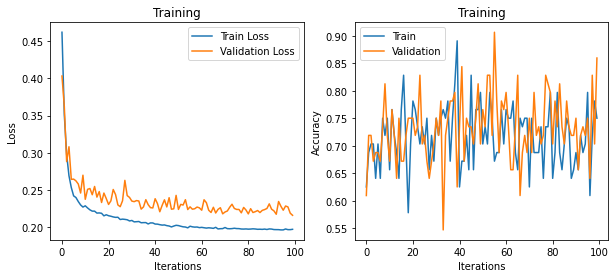

In [126]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training")
plt.plot(iters, losses, label="Train Loss")
plt.plot(iters,loss_test,label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend(loc='best')
plt.subplot(1,2,2)
plt.title("Training")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [112]:
t_df = pd.read_csv("test_data.csv", delimiter=',')
t_df

t_df['TimeToBusStopEncoded']= label_encoder.fit_transform(t_df['TimeToBusStop'])
t_df['TimeToSubwayEncoded']= label_encoder.fit_transform(t_df['TimeToSubway'])  
t_df
t_df = t_df.drop(columns=["TimeToBusStop","TimeToSubway"])

t_df.HallwayType.unique()
t_df = onehot_encode(t_df, 'HallwayType', 'HallwayTypeEncoded')
t_df.AptManageType.unique()
t_df = onehot_encode(t_df, 'AptManageType', 'AptManageTypeEncoded')
t_df.SubwayStation.unique()
t_df = onehot_encode(t_df, 'SubwayStation', 'SubwayStationEncoded')
t_df.HeatingType.unique()
t_df = onehot_encode(t_df, 'HeatingType', 'HeatingTypeEncoded')


'''bin_TimeToBusStopEncoded = 7
bin_TimeToSubwayEncoded= 7
bin_N_SchoolNearBy_Total = 7
bin_N_FacilitiesNearBy_Total = 7
bin_N_FacilitiesInApt= 7
bin_N_elevators= 7
bin_N_manager = 4
bin_N_Parkinglot_Basement= 12
bin_N_Parkinglot_Ground = 10
bin_Floor= 7
bin_Size_sqf = 12
bin_YearBuilt = 12'''

testTimeToBusStopEncoded,t_df = fdf2bindf(t_df,"TimeToBusStopEncoded", std, 1, bin_TimeToBusStopEncoded) 
testTimeToSubwayEncoded,t_df = fdf2bindf(t_df,"TimeToSubwayEncoded", std, 1, bin_TimeToSubwayEncoded) 
testN_SchoolNearBy_Total,t_df = fdf2bindf(t_df,'N_SchoolNearBy(Total)',std, 1, bin_N_SchoolNearBy_Total)
testN_FacilitiesNearBy_Total,t_df = fdf2bindf(t_df,'N_FacilitiesNearBy(Total)',std, 1, bin_N_FacilitiesNearBy_Total)
testN_FacilitiesInApt,t_df = fdf2bindf(t_df,"N_FacilitiesInApt", std, 1, bin_N_FacilitiesInApt)
testN_elevators,t_df = fdf2bindf(t_df,'N_elevators',std, 1, bin_N_elevators)
testN_manager,t_df = fdf2bindf(t_df,'N_manager',std, 1, bin_N_manager)
testN_Parkinglot_Basement,t_df = fdf2bindf(t_df,'N_Parkinglot(Basement)',std, 1, bin_N_Parkinglot_Basement)
testN_Parkinglot_Ground,t_df = fdf2bindf(t_df,'N_Parkinglot(Ground)',std, 1, bin_N_Parkinglot_Ground)
testFloor,t_df = fdf2bindf(t_df,'Floor',std, 1, bin_Floor)
testSize_sqf,t_df = fdf2bindf(t_df,'Size(sqf)',std, 1, bin_Size_sqf)
testYearBuilt,t_df = fdf2bindf(t_df,'YearBuilt', std, 1, bin_YearBuilt)
torch.from_numpy(testTimeToBusStopEncoded.values.astype(float)).float()
testTimeToBusStopEncoded_torch = torch.from_numpy(testTimeToBusStopEncoded.values.astype(float)).float()
testTimeToSubwayEncoded_torch = torch.from_numpy(testTimeToSubwayEncoded.values.astype(float)).float()
testN_SchoolNearBy_Total_torch = torch.from_numpy(testN_SchoolNearBy_Total.values.astype(float)).float()
testN_FacilitiesNearBy_Total_torch = torch.from_numpy(testN_FacilitiesNearBy_Total.values.astype(float)).float()
testN_FacilitiesInApt_torch = torch.from_numpy(testN_FacilitiesInApt.values.astype(float)).float()
testN_elevators_torch = torch.from_numpy(testN_elevators.values.astype(float)).float()
testN_manager_torch = torch.from_numpy(testN_manager.values.astype(float)).float()
testN_Parkinglot_Basement_torch = torch.from_numpy(testN_Parkinglot_Basement.values.astype(float)).float()
testN_Parkinglot_Ground_torch = torch.from_numpy(testN_Parkinglot_Ground.values.astype(float)).float()
testFloor_torch = torch.from_numpy(testFloor.values.astype(float)).float()
testSize_sqf_torch = torch.from_numpy(testSize_sqf.values.astype(float)).float()
testYearBuilt_torch = torch.from_numpy(testYearBuilt.values.astype(float)).float()

test_rest_train_torch = torch.from_numpy(t_df.values.astype(float)).float()
testa,testb,testc,testd,teste,testf,testg,testh,testi,testj,testk,testl,testm = test_rest_train_torch,testTimeToBusStopEncoded_torch,testTimeToSubwayEncoded_torch,testN_SchoolNearBy_Total_torch,testN_FacilitiesNearBy_Total_torch,testN_FacilitiesInApt_torch,testN_elevators_torch,testN_manager_torch,testN_Parkinglot_Basement_torch,testN_Parkinglot_Ground_torch,testFloor_torch,testSize_sqf_torch,testYearBuilt_torch 


In [114]:
test_ds = data.TensorDataset(testa,testb,testc,testd,teste,testf,testg,testh,testi,testj,testk,testl,testm)
test_loader = data.DataLoader(test_ds, batch_size=128, shuffle=False)

In [127]:
### TEST 
labels_pred = []
labels_prob_pred = []

for a,b,c,d,e,f,g,h,i,j,k,l,m in iter(test_loader):
  model.eval()
  a,b,c,d,e,f,g,h,i,j,k,l,m = a.to(device),b.to(device),c.to(device),d.to(device),e.to(device),f.to(device),g.to(device),h.to(device),i.to(device),j.to(device),k.to(device),l.to(device),m.to(device) 
  out = model(a,b,c,d,e,f,g,h,i,j,k,l,m).squeeze()
  condition = out.argmax(dim=1)
  output_list = condition.float().tolist()
  print(condition)
  output_l = []
  for item in output_list:
    output_l.append(item)
  #output_list = [item[0] for item in output_list]
  for item in output_l:
    labels_pred.append(item)
  for item in out.float().tolist():
    labels_prob_pred.append(item[0])

df_results = pd.DataFrame({
    "labels_pred": labels_pred})
"""df_results = pd.DataFrame({
    "labels_pred": labels_pred,
    "labels_prob_pred": labels_prob_pred })"""
df_results.to_csv("df_results.csv", index=None)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 